# Degerby Proxy

Time series of daily Baltic Sea volume, reconstructed
from  observations  of  sea  surface  elevation  at  tide
gauge Degerby, are available for 9 yr, i.e. 1980 to 1988
(Launiainen & Vihma 1990b). It is well known that sea
level  change  in  the  centre  of  the  Baltic  Sea  (e.g.
Degerby  or  Landsort)  is  representative  of  volume
change,  i.e.  the  mean  sea  level  change  of  the  whole
Baltic Sea (e.g. Jacobsen 1980).

# About GESLA3

We converted height units to metres, the time zone of each record was adjusted to Coordinated Universal Time (UTC).

We did not adjust the frequency of the station records, which in all cases was at least hourly, although several sources have data at higher-frequency (15, 10 or 6 minutes)

We use total water levels from the GESLA-2 
dataset (Tiggeloven 2021)

# Questions

- Isnt SL Degerby positive correlated to storm surges around BS anyways? So does it even make sense to take it as a predictor?
- How many days of timelag should I use for prefilling? (look at theory part, maybe 7 days)

In [1]:
from data import data_loader
from data import gesla_preprocessing
from data import era5_preprocessing
from data import preprocessing
from data import saver
from data import visualisation

Load Predictand from GESLA


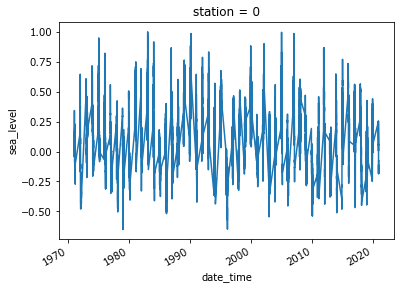

In [2]:
#---
# Load degerby station values as proxy for prefilling
#---

station_names = ['degerby-deg-fin-cmems',]
season = "winter"
degerby_proxy = data_loader.load_gesla(station_names)

# Select a season
#---
degerby_proxy = gesla_preprocessing.select_season(degerby_proxy, season)

# Select only sea_level analysis data
#---
degerby_proxy = gesla_preprocessing.get_analysis(degerby_proxy)
degerby_proxy = degerby_proxy["sea_level"] # Select values
degerby_proxy = degerby_proxy.to_xarray()

degerby_proxy.plot()

Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95


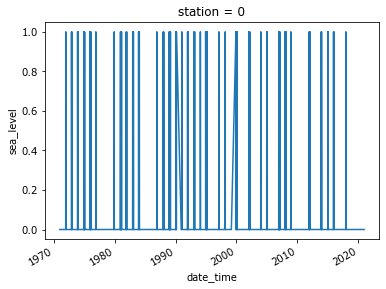

In [3]:
#--- 
# Load predictand
#---
season = "winter"
station_names = ["hanko-han-fin-cmems",]
percentile = 0.95

# Load Predictand
#---
gesla_predictand = data_loader.load_gesla(station_names)

# Get lon/lat positions of stations
#---
station_positions = gesla_preprocessing.station_position(gesla_predictand, station_names)

# Select a season
#---
gesla_predictand = gesla_preprocessing.select_season(gesla_predictand, season)

# Select only sea_level analysis data
#---
gesla_predictand = gesla_preprocessing.get_analysis(gesla_predictand)
gesla_predictand = gesla_predictand["sea_level"] # Select values

# Detrend 
#---
gesla_predictand = gesla_preprocessing.detrend(gesla_predictand, level="station",) # TODO: Make it possible to detrend by subtracting trend instead of mean

# Apply one hot encoding
#---
gesla_predictand = gesla_preprocessing.apply_dummies(gesla_predictand, percentile=percentile, level="station")
print(f"Applied one-hot-encoding with Percentile: {percentile}")
gesla_predictand = gesla_predictand.to_xarray()

gesla_predictand.plot()

In [83]:
degerby_proxy

<xarray.DataArray 'sea_level' (station: 1, date_time: 106298)>
array([[ 0.028,  0.025,  0.021, ..., -0.084, -0.079, -0.076]])
Coordinates:
  * station    (station) int64 0
  * date_time  (date_time) datetime64[ns] 1971-01-01 ... 2020-12-17T07:00:00

In [57]:
#---
# Intersect time
#---
def intersect_time(predictor, predictand, is_prefilling):
    """
    Description:
        Returns data of predictor and predictand in overlapping time-intervall.

    Parameters:
        predictor (xr.DataArray): Predictor values as a timeseries with lat, lon
        predictand (xr.DataArray): Predictand values as a timeseries per station
        is_prefilling (bool): If the predictor is prefilling of Baltic Sea, e.g. Degerby SL as a proxy

    Returns:
        X, Y, t
        X (np.array, float): Predictor values as a field time series. Shape:(time, lat, lon)
        Y (np.array, float): Predictand at selected stations. Shape:(time, stations)
        t (np.array, datetime.date): Time-series for x, y. Shape:(time,)
    """

    #---
    # Predictor and predictand values of overlapping time series
    #
    # GESLA data is hourly. Needs to be daily, like ERA5. 
    #---
    import pandas as pd
    import numpy as np
    predictand_time = pd.to_datetime(predictand.date_time.values).date
    predictor_values = predictor.values # Daily (ERA5) or hourly (Degerby) data
    predictand_values = predictand.values # Hourly data

    if is_prefilling:
        predictor_time = pd.to_datetime(predictor.date_time.values).date
        predictor_values = np.swapaxes(predictor_values, axis1=0, axis2=1)
    else:
        predictor_time = pd.to_datetime(predictor.time.values).date

    # Choose maximum per day, i.e. if one hour
    # a day indicates an extreme surge, the whole day 
    # is seen as extreme surge.
    print("Get overlapping timeseries of ERA5 and GESLA")

    predictand_dmax = []
    for date in predictor_time:
        time_idx = np.where(predictand_time==date)[0] # Intersection of timeseries'
        if time_idx.shape[0] == 0: # If no intersection
            time_idx = np.where(predictor_time==date)[0] # Find poistion in (updated) predictor timeseries
            predictor_values = np.delete(predictor_values, time_idx, axis=0) # Update predictor timeseries to match predictand
            predictor_time = np.delete(predictor_time, time_idx, axis=0) # Update predictor timepoints
            print(f"date:{date} at position {time_idx} was deleted as it was in predictor data but not in predictand data") 
        else:
            dmax = np.max(predictand_values[:, time_idx], axis=1) # Daily maximum of predictand
            predictand_dmax.append(dmax)

    predictand_dmax = np.array(predictand_dmax)

    X = predictor_values
    Y = predictand_dmax
    t = predictor_time
        
    return X, Y, t

In [58]:
X, Y, t = intersect_time(degerby_proxy, gesla_predictand, is_prefilling=True)

Get overlapping timeseries of ERA5 and GESLA


In [61]:
print(X.shape)
print(Y.shape)

(106298, 1)
(106298, 1)


In [59]:
# Load data of predictor
#---
preprocess = "preprocess1" # ["preprocess1"]
range_of_years = "1999-2008" # ["1999-2008", "2009-2018", "2019-2022",] 
subregion = "lon-0530_lat7040" # ["lon-0530_lat7040"]
predictor = "sp"

era5_predictor = data_loader.load_daymean_era5(range_of_years, subregion, season, predictor, preprocess)
era5_predictor = preprocessing.convert_timestamp(era5_predictor, dim="time")
era5_predictor.shape

timeseries is already of dtype datetime64[ns]


(903, 121, 141)

In [60]:

# Convert predictor sp.unit from Pa to hPA
#---       
X_, Y_, t_ = intersect_time(era5_predictor, gesla_predictand, is_prefilling=False)

Get overlapping timeseries of ERA5 and GESLA


In [62]:
print(X_.shape)
print(Y_.shape)

(903, 121, 141)
(903, 1)


In [63]:
def timelag(X, Y, t, timelag):
    """
    Description: 
        Returns timelagged predictor data X_timelag for predictand Y_timelag.
        Shifts predictand data Y according to the given timelag.
    Parameters:
        X (np.array, float): Predictor values as a field time series. Shape:(time, lat, lon)
        Y (np.array, float): Predictand at selected stations. Shape:(time, stations)
        t (np.array, datetime.date): Time-series of intersected timepoints of X and Y. Shape:(time,)
        timelag (int): timelag for predictor data X. Dimension of timelag depends on timeseries-interval of X.
    Returns:
        X_timelag (np.array, float): Predictor values as a field time series (timelagged). Shape:(time, lat, lon)
        Y_timelag (np.array, float): Predictand at selected stations. Shape:(time, stations)
        t_predictor (np.array, datetime.date): Time-series of X (timelagged). Shape:(time,)
        t_predictand (np.array, datetime.date): Time-series of Y. Shape:(time,)

    """
    n_timepoints = len(t)
    # Timelag of predictor 
    # Return predictor data and corresponding timeseries
    #---
    t_predictor = t[:(n_timepoints-timelag)]
    X_timelag =  X[:(n_timepoints-timelag)]

    # Return Predictand data (not lagged) and corresponding timeseries
    #---
    t_predictand = t[timelag:]
    Y_timelag = Y[timelag:]

    return (X_timelag, Y_timelag, t_predictor, t_predictand)

def combine_timelags(X, Y, timelags):
    """
    Description:
        Returns combined timelagged predictor data X_timelag for predictand Y_timelag.
        Shifts predictand data Y according to the maximum timelag given in timelags.
        Note: Input data X, Y needs to be on the same time-interval (see preprocessing.intersect_time)
        
    Parameters:
        X (np.array, float): Predictor values as a field time series. Shape:(n_labels, lat, lon)
        Y (np.array, float): Predictand at selected stations. Shape:(n_labels, stations)
        timelags (list): List of timelags in days
    Returns:
        X_timelag (np.array, float): Combined timelagged Predictor values in increasing order of timelags, e.g. t=0, t=1,..., Shape:(timelag, n_labels, lat, lon)
        Y_timelag (np.array, float): Timelagged Predictand at selected stations. Shape:(n_labels, stations)
    """
    import numpy as np
    # Initialize
    #---

    timelags.sort()
    max_timelag = max(timelags)

    # Get timelagged Predictand 
    #---
    Y_timelag = Y[max_timelag:]

    # Get timelagged predictors
    #---
    X_timelag = []

    for timelag_ in timelags:

        assert timelag_ >= 0, f"Timelag = {timelag_} needs to be a positive integer"

        idx = max_timelag - timelag_

        if timelag_ > 0:
            X_tmp = X[idx : - timelag_]
        if timelag_ == 0: 
            X_tmp = X[idx:]

        X_timelag.append(X_tmp)

    X_timelag = np.array(X_timelag)

    return X_timelag, Y_timelag


In [65]:
#---
# Introduce timelag
# Note: Predictor data is hourly
#---
import numpy as np
timelags = np.array([7, 0, 2, ]) * 24
print(f"Introduce timelags: {timelags}")

X_timelag, Y_timelag = preprocessing.combine_timelags(X, Y, timelags,)

Introduce timelags: [168   0  48]


In [84]:
print(X_timelag.shape)
print(Y_timelag.shape)

(1, 106130, 1)
(106130, 1)


(106130, 1, 1)

In [71]:
#---
# Reshape for train test split
#---
ndim = Y_timelag.shape[0]
X = X_timelag.swapaxes(0,1)
X = X.reshape(ndim, -1) # Reshapes into (time, timelag1pred1_lonlats:timelag1pred2_lonlats:...:timelag1predn_lonlats:timelag2pred1_lonlats,...:timelagnpredn_lonlats)
y = Y_timelag[:, 0] # Select one station
#---
# Handle NaN Values
#---

# Insert numerical value that is not in data.
# ML will hopefully recognize it.
X[np.where(np.isnan(X))] = -999

print(X.shape)
print(y.shape)

(106130, 3)
(106130,)


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

#---
# Apply train-test split
#---
random_state = 0
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=test_size)

# Degerby Proxy

In [86]:
#---
# Load data of predictor
#---
def load_pf(season):
    station_names = ['degerby-deg-fin-cmems',]
    degerby_proxy = data_loader.load_gesla(station_names)

    # Select a season
    #---
    degerby_proxy = gesla_preprocessing.select_season(degerby_proxy, season)

    # Select only sea_level analysis data
    #---
    degerby_proxy = gesla_preprocessing.get_analysis(degerby_proxy)
    degerby_proxy = degerby_proxy["sea_level"] # Select values
    degerby_proxy = degerby_proxy.to_xarray()

    return degerby_proxy

In [80]:
#---
# Intersect time
#---
X, Y, t = intersect_time(degerby_proxy, gesla_predictand, is_prefilling=True)
print(X.shape)
print(Y.shape)

Get overlapping timeseries of ERA5 and GESLA
(106298, 1)
(106298, 1)


In [82]:
#---
# Introduce timelag
# Note: Predictor data is hourly
#---
import numpy as np
timelags = np.array([7, ]) * 24
print(f"Introduce timelags: {timelags}")

X_timelag, Y_timelag = preprocessing.combine_timelags(X, Y, timelags,)

print(X_timelag.shape)
print(Y_timelag.shape)

Introduce timelags: [168]
(1, 106130, 1)
(106130, 1)


# Era5

In [77]:
#---
# Load data of predictor
#---
import xarray as xr
if predictor == "pf":
    era5_predictor = load_pf()
else:
    era5_predictor = data_loader.load_daymean_era5(range_of_years, subregion, season, predictor, preprocess)
    era5_predictor = preprocessing.convert_timestamp(era5_predictor, dim="time")

# Convert predictor sp.unit from Pa to hPA
#---
if predictor == "sp":
    with xr.set_options(keep_attrs=True):
        old_unit = era5_predictor.attrs["units"]
        era5_predictor = era5_predictor / 100
        era5_predictor.attrs["units"] = "hPa"
        new_unit = era5_predictor.attrs["units"]
        print(f"Converted units of {predictor} from {old_unit} to {new_unit}")

timeseries is already of dtype datetime64[ns]
Converted units of sp from Pa to hPa
Get overlapping timeseries of ERA5 and GESLA
(903, 121, 141)
(903, 1)


In [78]:
#---
# Intersect time
#---       
X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand)

print(X_.shape)
print(Y_.shape)

Get overlapping timeseries of ERA5 and GESLA
(903, 121, 141)
(903, 1)


In [ ]:
#---
# Get timelags
#---
print(f"Introduce timelags: {timelags}")

X_timelag, Y_timelag = preprocessing.combine_timelags(X_, Y_, timelags)

X.append(X_timelag)
Y.append(Y_timelag)
t.append(t_)

# # Save unit and name of predictor
# #---
for timelag_ in timelags:
    if predictor == "pf":
        pred_units.append("m")
        pred_names.append(f"{predictor}_tlag{timelag_}")
    else:
        pred_units.append(era5_predictor.units)
        pred_names.append(f"{era5_predictor.name}_tlag{timelag_}")

# Convert to format needed for model fit
#---      
X = np.array(X)
Y = np.array(Y) 
Y = Y[0, :] # Assume all timeseries are the same for the predictors.
t = np.array(t)

# Reshape for model input
#---
print(f"Reshape for model input")

ndim = Y.shape[0]

if predictor == "pf":
    X = X.swapaxes(0, 1)
else:
    X = X.swapaxes(0, 2) # Put time dimension to front
    
print(X.shape) # (time, timelags, predictor_combination, lon?, lat?)

X = X.reshape(ndim, -1) # Reshapes into (time, timelag1pred1_lonlats:timelag1pred2_lonlats:...:timelag1predn_lonlats:timelag2pred1_lonlats,...:timelagnpredn_lonlats)
y = Y[:, 0] # Select one station

#---
# Handle NaN Values
#---

# Insert numerical value that is not in data.
# ML will hopefully recognize it.
X[np.where(np.isnan(X))] = -999

print("Data is prepared as follows")
print(f"X.shape : {X.shape}")
print(f"y.shape : {y.shape}")
print(f"pred_names : {pred_names}")
print(f"pred_units : {pred_units}")

# Main

In [1]:
#---
# Modules
#---
import numpy as np
import xarray as xr
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


from data import data_loader
from data import gesla_preprocessing
from data import era5_preprocessing
from data import preprocessing
from data import saver
from data import visualisation

from models import modelfit
from models import evaluation
from models import loader

In [5]:
def run(
model_run, 
run_id, 
season,
station_names, 
predictors_of_model, 
timelags_of_model, 
models_path, 
percentile, 
clf, 
hparam_grid, 
optimizer, 
k, 
n_iter, 
random_state,
test_size,
is_optimized, 
is_scaled,
is_overlay_importance,
is_station_name,
):
    """
    Description:
        Builds a model to predict (percentile) extreme storm surges at station_names using predictors for a specified season by using
        a classifier.
    Parameters:
        season (str): Either winter or autumn
        predictors (list): List of predictors (X) used to predict Storm Surge (y)
        percentile (float): Percentile of Extreme Storm Surges
        station_names (list): List of stations used from GESLA data-set
        clf (sklearn.modeltype): Used model to do prediction, e.g. RandomForestClassifier, LogisticRegression,...
        hparam_grid (dict): Selection of multiple Hyperparameters either used for building the model or fitted 
                            to clf via the optimizer depending on is_optimized.
                            If hparam_grid is used for optimization, values of dictionary need to be lists.
        optimizer (str): Optimizer for automatic search of hyperparameters, either GridSearchCV or RandomSearchCV
        run_id (int): Number of the run (used for saving output)
        model_run (str): Naming of the model run (used for saving output)
        k (int): Number of k-fold crossvalidations in model fit (Defaults: 3)
        n_iter (int): Number of combinations used for RandomizedSearchCV (Defaults: None)
        is_optimized (bool): Whether or not to search best combination of hparams within hparam_grid with 
                             the optimizer (Defaults: True)
                             If is_optiomized == False, hyperparameters are loaded from a model given in models_path
        is_scaled (bool): Use StandardScaler to scale data if it is on different scales (Defaults: False)
    Returns:
        None. Saves Output in results>random_forest>model_run folder. Saves model in models>random_forest>model_run
    """
    import sys
    #--- 
    # Initialize
    #---
    preprocess = "preprocess1" # ["preprocess1"]
    range_of_years = "1999-2008" # ["1999-2008", "2009-2018", "2019-2022",] 
    subregion = "lon-0530_lat7040" # ["lon-0530_lat7040"]
    lats, lons = preprocessing.get_lonlats(
        range_of_years,
        subregion,
        season,
        predictor="sp", # Does not matter which predictor. All predictors are sampled on same lon-lat field.
        era5_import=preprocess,
        )
    colorbar_range = { # vmin vmax values for colorbar of predictor maps
        'sp': np.array([ 980., 1020.,]),  # Low pressure systems <980hPa (see Theory Part)
        'tp': np.array([0.    , 0.0018]),
        'u10': np.array([-17.2,  17.2]), # Storm is defined by wind stronger than 17.2m/s
        'v10': np.array([-17.2,  17.2]),
        }
    nlevels = 10 # For contourplot of predictor maps
    orig_stdout = sys.stdout # Original Output for print etc.
    

    #---
    # Preprocess GESLA Data
    #---

    # Load Predictand
    #---
    gesla_predictand = data_loader.load_gesla(station_names)

    # Get lon/lat positions of stations
    #---
    station_positions = gesla_preprocessing.station_position(gesla_predictand, station_names)

    # Select a season
    #---
    gesla_predictand = gesla_preprocessing.select_season(gesla_predictand, season)

    # Select only sea_level analysis data
    #---
    gesla_predictand = gesla_preprocessing.get_analysis(gesla_predictand)
    gesla_predictand = gesla_predictand["sea_level"] # Select values

    # Detrend 
    #---
    gesla_predictand = gesla_preprocessing.detrend(gesla_predictand, level="station",) # TODO: Make it possible to detrend by subtracting trend instead of mean

    # Apply one hot encoding
    #---
    gesla_predictand = gesla_preprocessing.apply_dummies(gesla_predictand, percentile=percentile, level="station")
    print(f"Applied one-hot-encoding with Percentile: {percentile}")

    # Convert to DataArray
    # nan values: no measurement at that timestamp for specific station
    #---
    gesla_predictand = gesla_predictand.to_xarray()

    #---
    # Loop over all run_ids of a model_run / predictors
    #---
    for idx, predictors in enumerate(predictors_of_model): # Loops over separate modelruns 

        #---
        # Save printed output to file
        #---
        # folder = f"results/random_forest/{model_run}/"
        # saver.directory_existance(folder)
        # file_path = f'{folder}output_runid{run_id}.txt'
        # sys.stdout = open(file_path, "w") 

        #---
        # Load ERA5- Predictor
        #---
        
        # Initialize
        #---
        timelags = timelags_of_model[idx]
        X = []
        Y = []
        t = []
        pred_units = []
        pred_names = []
        tic_main = time.perf_counter()

        # Main
        #---
        for predictor in predictors:
            print(f"Add predictor {predictor} to model input features")

            # Load data of predictor
            #---
            import xarray as xr
            if predictor == "pf":
                era5_predictor = data_loader.load_pf(season)
                is_prefilled = True
            else:
                era5_predictor = data_loader.load_daymean_era5(range_of_years, subregion, season, predictor, preprocess)
                era5_predictor = preprocessing.convert_timestamp(era5_predictor, dim="time")
                is_prefilled = False
            
            # Convert predictor sp.unit from Pa to hPA
            #---
            if predictor == "sp":
                with xr.set_options(keep_attrs=True):
                    old_unit = era5_predictor.attrs["units"]
                    era5_predictor = era5_predictor / 100
                    era5_predictor.attrs["units"] = "hPa"
                    new_unit = era5_predictor.attrs["units"]
                    print(f"Converted units of {predictor} from {old_unit} to {new_unit}")
                    
            X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand, is_prefilled)

            #---
            # Get timelags
            #---
            print(f"Introduce timelags: {timelags}")

            X_timelag, Y_timelag = preprocessing.combine_timelags(X_, Y_, timelags)

            X.append(X_timelag)
            Y.append(Y_timelag)
            t.append(t_)

            # # Save unit and name of predictor
            # #---
            for timelag_ in timelags:
                if predictor == "pf":
                    pred_units.append("m")
                    pred_names.append(f"{predictor}_tlag{timelag_ // 24}") # Timelag in hours for pf
                else:
                    pred_units.append(era5_predictor.units)
                    pred_names.append(f"{era5_predictor.name}_tlag{timelag_}")

            # Convert to format needed for model fit
            #---      
            X = np.array(X)
            Y = np.array(Y) 
            Y = Y[0, :] # Assume all timeseries are the same for the predictors.
            t = np.array(t)

            # Reshape for model input
            #---
            print(f"Reshape for model input")

            ndim = Y.shape[0]

            if predictor == "pf":
                X = X.swapaxes(0, 1)
            else:
                X = X.swapaxes(0, 2) # Put time dimension to front
                
            print(X.shape) # (time, timelags, predictor_combination, lon?, lat?)

            X = X.reshape(ndim, -1) # Reshapes into (time, timelag1pred1_lonlats:timelag1pred2_lonlats:...:timelag1predn_lonlats:timelag2pred1_lonlats,...:timelagnpredn_lonlats)
            y = Y[:, 0] # Select one station

            #---
            # Handle NaN Values
            #---

            # Insert numerical value that is not in data.
            # ML will hopefully recognize it.
            X[np.where(np.isnan(X))] = -999

            print("Data is prepared as follows")
            print(f"X.shape : {X.shape}")
            print(f"y.shape : {y.shape}")
            print(f"pred_names : {pred_names}")
            print(f"pred_units : {pred_units}")
        
        #---
        # Apply Train-Test split 
        #---
        print("Apply train-test-split")
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=test_size)

        # ---
        # Detrend train-test sets separately
        # ---

        # # Convert to expected format 
        # #---
        # test_index = np.zeros(y_test.shape).astype(int) # All zeros because we only selected one station
        # train_index = np.zeros(y_train.shape).astype(int)

        # y_test = array_to_series(y_test, test_index, index_name="station", series_name="sea_level") # DONE: Add do module: Preprocessing
        # y_train = array_to_series(y_train, train_index, index_name="station", series_name="sea_level")

        # # Detrend
        # # ---
        # print("Detrend train-test data for predictand")
        # y_test = gesla_preprocessing.detrend(y_test, level="station")
        # y_train = gesla_preprocessing.detrend(y_train, level="station")

        # # # Apply one hot encoding
        # #---
        # y_test = gesla_preprocessing.apply_dummies(y_test, percentile=percentile, level="station")
        # print(f"Applied one-hot-encoding to test-set with Percentile: {percentile}")

        # y_train = gesla_preprocessing.apply_dummies(y_train, percentile=percentile, level="station")
        # print(f"Applied one-hot-encoding to train-set with Percentile: {percentile}")

        # print(f"{y_train.size} training datapoints used")
        
        # # Convert to DataArray
        # # nan values: no measurement at that timestamp for specific station
        # #---
        # y_test = y_test.to_xarray()
        # y_train = y_train.to_xarray()
        
        #---
        # Scale data if they are on different scales
        #---
        if is_scaled:
            print("Scale training data")
            s = StandardScaler()
            s.fit(X_train)
            X_train = s.transform(X_train)
            X_test = s.transform(X_test)

        #---
        #  Optimize Hyperparameters
        #---
        if is_optimized:
            print(f"Optimize Hyperparameters using {optimizer}")
            print(f"Tested Hyperparameters: {hparam_grid}")
            
            hparam_grid_opt = modelfit.optimize_hyperparameter(X_train, y_train, clf(), optimizer, hparam_grid, k, n_iter, n_jobs=-1)
        
        if not is_optimized:
            model_path = models_path[idx]
            print(f"Hyperparameters are loaded from model: {model_path}")
            with open(model_path, 'rb') as f:
                model = pickle.load(f)

            hparam_grid_opt = model.get_params()
            
        #---
        #  Save hyperparameters
        #---
        folder = f"models/random_forest/{model_run}/" 
        saver.directory_existance(folder)
        saver.save_hpdict(hparam_grid_opt, run_id, model_run, percentile, folder)

        print("Saved Hyperparameters")

        #---
        # Fit the model
        #---
        print(f"Fit model with hyperparameters {hparam_grid_opt}")

        model = clf(**hparam_grid_opt) # One can set parameters afterwards via model.set_params() 

        model.fit(X_train, y_train)

        #---
        # Saving the model
        #---
        print("Save model")
        filename = f'{model_run}_{optimizer}_{run_id}.sav'
        pickle.dump(model, open(f'{folder}{filename}', 'wb'))

        #---
        # Plot Predictor Maps
        #---
        tic_predmap = time.perf_counter()
        visualisation.predictor_maps(
            model, X_test, y_test, 
            lons, lats, pred_units, pred_names, 
            station_positions, station_names, is_station_name, 
            is_overlay_importance, 
            run_id, model_run, 
            percentile=99., markersize=5, alpha=0.08, color="k", colorbar_range=colorbar_range, nlevels=nlevels,
            )
        toc_predmap = time.perf_counter()
        time_predmap = toc_predmap - tic_predmap # Save time of this separately as it is not necessary for model predictions

        #---
        # Evaluate model / Diagnostic
        #--- 
        print("Evaluate Model \n")

        # Score & Importance
        #---
        test_score = model.score(X_test, y_test)
        train_score = model.score(X_train, y_train)
        relative_score = evaluation.relative_scores(train_score, test_score)
        importance = model.feature_importances_

        # Save Scores & Importance
        #---
        folder = f"results/random_forest/{model_run}/"
        saver.directory_existance(folder)

        fname = f"importance_{str(percentile)[-2:]}_{run_id}"
        np.save(f"{folder}{fname}", importance)
        print(f"saved importance to : {folder}{fname}")

        fname = f"testscore_{str(percentile)[-2:]}_{run_id}"
        np.save(f"{folder}{fname}", test_score)
        print(f"saved testscore to : {folder}{fname}")

        fname = f"trainscore_{str(percentile)[-2:]}_{run_id}"
        np.save(f"{folder}{fname}", train_score)
        print(f"saved trainscore to : {folder}{fname}")

        fname = f"relativescore_{str(percentile)[-2:]}_{run_id}"
        np.save(f"{folder}{fname}", relative_score)
        print(f"saved relativescore to : {folder}{fname}")

        # Plot importance of each predictor from combination
        # Goal:
        # 1. Separate importance per predictor
        # 2. Plot importance of each predictor on lon lat map
        #---
        n_pred_features = len(lons) * len(lats) # Features per predictor (lon/lat Input-Field). Needed for importance separation

        predictor_importances = evaluation.separate_predictor_importance(importance, n_pred_features)

        for pred_idx, pred_importance in enumerate(predictor_importances):
            # Plot importance map and save it
            predictor = pred_names[pred_idx] 
            tflag = f"{predictor}_{str(percentile)[-2:]}"
            
            if predictor == "pf":
                pass
            else:
                fig, ax = evaluation.importance_map(pred_importance, lons, lats, tflag)

                # Add position of station to map
                #---
                for station_name in station_names:
                    visualisation.plot_station(ax, station_positions, station_name, is_station_name)
                    
                fname = f"importance_{predictor}_{str(percentile)[-2:]}_{run_id}"
                fig.savefig(f"{folder}{fname}.pdf")

        #---
        # Confusion matrix
        #---
        # Format: 
        # Reality / Model: Negative, Positive
        # Negative    Right Negative, False Positive 
        # Positive    False Negative, Right Positive

        print("Show Confusion Matrix on testdata \n")
        cfm_fig1 = evaluation.plot_cf(model, X_test, y_test)
        cfm_fig1.show()

        print("Show Confusion Matrix on traindata \n")
        cfm_fig2 = evaluation.plot_cf(model, X_train, y_train)
        cfm_fig2.show()

        # Save CFM
        fname = f"{folder}testcf_matrix_{str(percentile)[-2:]}_{run_id}.pdf"
        cfm_fig1.savefig(fname)
        print(f"saved cf matrix to : {fname}")

        fname = f"{folder}traincf_matrix_{str(percentile)[-2:]}_{run_id}.pdf"
        cfm_fig2.savefig(fname)
        print(f"saved cf matrix to : {fname}")

        # Calculate CFM-Metrics
        metrics1 = evaluation.cfm_metrics(model, X_test, y_test)
        metrics2 = evaluation.cfm_metrics(model, X_train, y_train)

        fname = f"testcf_metrics_{str(percentile)[-2:]}_{run_id}.pkl"
        with open(f"{folder}{fname}", 'wb') as f:
            pickle.dump(metrics1, f)

        fname = f"traincf_metrics_{str(percentile)[-2:]}_{run_id}.pkl"
        with open(f"{folder}{fname}", 'wb') as f:
            pickle.dump(metrics2, f)

        print(f"saved cf metrics to : {fname}")

        #---
        # AUROC
        # Receiver Operating Characteristics & Area Under the Curve
        #---

        print("Show AUROC \n")

        y_test_proba = model.predict_proba(X_test)[:, 1] # Prob. for predicting 0 or 1, we only need second col

        fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
        auc = roc_auc_score(y_test, y_test_proba)

        print(f'AUC: {auc}')

        fig, ax = plt.subplots(tight_layout=True)

        ax.plot(fpr, tpr)
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title(f"AUROC with AUC = {auc}")

        fig.show()

        fname = f"{folder}AUROC_{str(percentile)[-2:]}_{run_id}.pdf"
        fig.savefig(fname)
        print(f"saved AUROC to : {fname}")

        #--- 
        # Calculate runtime
        #---
        sec2min = 1 / 60
        toc_main = time.perf_counter()

        total_time = ((toc_main - tic_main) - time_predmap) * sec2min # Time of the whole model run excluding the computing time for predictor maps

        fname = f"clock_{run_id}"
        np.save(f"{folder}{fname}", total_time)
        print(f"saved runtime of {round(total_time, ndigits=2)} minutes to : {folder}{fname}")

        #---
        # Update run_id
        #---
        run_id = run_id + 1
        sys.stdout = orig_stdout # Restore original system output


In [6]:
#---
# Initialize
#---
model_run = "rf014_test_delete_later"
run_id = 0
season = "winter"
station_names = ["hanko-han-fin-cmems",]
predictors_of_model = [
    # ["sp",], 
    ["pf",],
]
timelags_of_model = [
    # [0,], 
    [7*24,],
]
models_path = [
    # None,
    None,  
]
percentile = 0.95
clf = RandomForestClassifier

# Build Hyperparameter Grid to optimize from.
#---
n_estimators = [int(x) for x in np.linspace(start = 0, stop = 1000, num = 10)] # Number of trees in random forest
max_depth = [int(x) for x in np.linspace(1, 4, num = 4)] # Maximum number of levels in tree

# max_depth.append(None)
# min_samples_split = [2, 5,] # Minimum number of samples required to split a node
# min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node
random_state = 0

hparam_grid = {'n_estimators': n_estimators, # hparam grid if optimization is needed
            'max_depth': max_depth,
            # 'min_samples_split': min_samples_split,
            # 'min_samples_leaf': min_samples_leaf,
            'criterion' : ['gini',],
            'random_state' : [random_state,], # To compare results when changing hyperparameters
            'class_weight' : ["balanced",], # “balanced_subsample"
            'oob_score' : [True,],
            }

optimizer = "GridSearchCV" #"RandomSearchCV"
k = 3
n_iter = 100 
test_size = 0.25
is_optimized = True # TODO: Maybe adjust this to be a list as predictor_of_models etc. s.t. one can decide whether to optimize or just load a model
is_scaled = False
is_overlay_importance = True
is_station_name = False 

In [7]:
run(
model_run, 
run_id, 
season,
station_names, 
predictors_of_model, 
timelags_of_model, 
models_path, 
percentile, 
clf, 
hparam_grid, 
optimizer, 
k, 
n_iter, 
random_state,
test_size,
is_optimized, 
is_scaled,
is_overlay_importance,
is_station_name,
)

Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Add predictor pf to model input features
Load Predictand from GESLA
Get overlapping timeseries of ERA5 and GESLA
Introduce timelags: [168]
Reshape for model input
(1, 1, 106130, 1)
Data is prepared as follows
X.shape : (106130, 1)
y.shape : (106130,)
pred_names : ['pf_tlag7']
pred_units : ['m']
